Using device: cuda


Processing test/nofire: 100%|██████████| 251/251 [00:08<00:00, 28.38it/s]


Original mean: tensor([0.4145, 0.4044, 0.3784])
Original std: tensor([0.2285, 0.2066, 0.2088])
Processed mean: tensor([0.4454, 0.4353, 0.4083])
Processed std: tensor([0.2399, 0.2157, 0.2105])


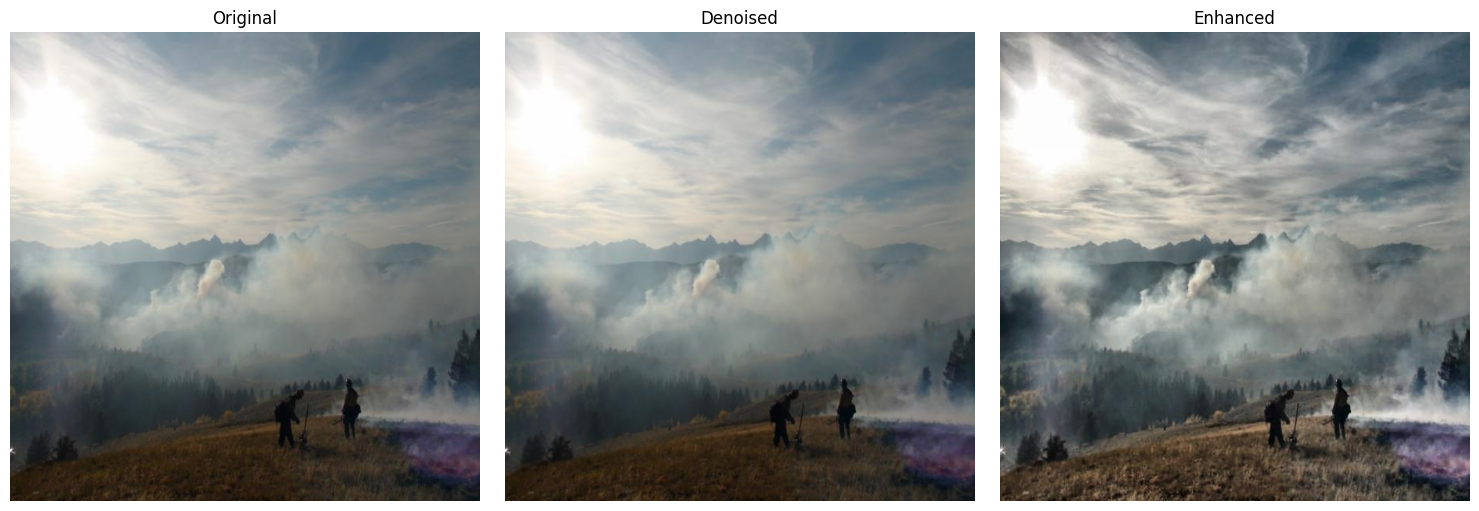

In [1]:
import os
from PIL import Image
import torch
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2

# -----------------------------
# CONFIG
# -----------------------------
base_dir = 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\resized'
denoised_dir = 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\denoised'
splits = ['train', 'val', 'test']
classes = ['fire', 'nofire']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -----------------------------
# DENOISING FUNCTIONS
# -----------------------------

def denoise_image(img_tensor):
    """Apply Gaussian blur for denoising"""
    gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
    return gaussian_blur(img_tensor.unsqueeze(0)).squeeze(0)

def enhance_image(img_tensor):
    """Apply CLAHE enhancement"""
    img_np = (img_tensor.cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab[:, :, 0] = clahe.apply(lab[:, :, 0])
    enhanced_np = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return torch.from_numpy(enhanced_np).permute(2, 0, 1).float() / 255.0

# -----------------------------
# DENOISING PIPELINE
# -----------------------------

means_original, stds_original = [], []
means_processed, stds_processed = [], []

for split in splits:
    for cls in classes:
        input_path = os.path.join(base_dir, split, cls)
        output_path = os.path.join(denoised_dir, split, cls)
        os.makedirs(output_path, exist_ok=True)

        img_files = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
        
        for img_name in tqdm(img_files, desc=f"Processing {split}/{cls}"):
            try:
                # Load and process image
                img = Image.open(os.path.join(input_path, img_name)).convert("RGB")
                img_tensor = transforms.ToTensor()(img).to(device)
                
                # Store original stats
                means_original.append(img_tensor.mean(dim=(1, 2)).cpu())
                stds_original.append(img_tensor.std(dim=(1, 2)).cpu())
                
                # Apply denoising and enhancement
                img_denoised = denoise_image(img_tensor)
                img_enhanced = enhance_image(img_denoised)
                
                # Store processed stats
                means_processed.append(img_enhanced.mean(dim=(1, 2)).cpu())
                stds_processed.append(img_enhanced.std(dim=(1, 2)).cpu())
                
                # Save result
                to_pil_image(img_enhanced.cpu()).save(os.path.join(output_path, img_name))
                
            except Exception as e:
                print(f"Error with {img_name}: {e}")

# -----------------------------
# STATISTICS
# -----------------------------
if means_original:
    mean_orig = torch.stack(means_original).mean(0)
    std_orig = torch.stack(stds_original).mean(0)
    mean_proc = torch.stack(means_processed).mean(0)
    std_proc = torch.stack(stds_processed).mean(0)

    print("Original mean:", mean_orig)
    print("Original std:", std_orig)
    print("Processed mean:", mean_proc)
    print("Processed std:", std_proc)

# -----------------------------
# VISUALIZATION
# -----------------------------
def show_sample():
    sample_path = os.path.join(base_dir, 'train', 'fire')
    if os.path.exists(sample_path):
        img_files = os.listdir(sample_path)
        if img_files:
            img_path = os.path.join(sample_path, img_files[0])
            img = Image.open(img_path).convert("RGB")
            img_tensor = transforms.ToTensor()(img).to(device)
            
            img_denoised = denoise_image(img_tensor)
            img_enhanced = enhance_image(img_denoised)
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            titles = ['Original', 'Denoised', 'Enhanced']
            images = [img, to_pil_image(img_denoised.cpu()), to_pil_image(img_enhanced.cpu())]
            
            for ax, title, image in zip(axes, titles, images):
                ax.imshow(image)
                ax.set_title(title)
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()

show_sample()